In [55]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Load test module for sanity check
from test_utils import test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Data Generation
===

In [56]:
np.random.seed(10)
P, Q = (np.random.rand(i, 2) for i in (4, 5))
P_big, Q_big = (np.random.rand(i, 80) for i in (100, 120))

print(P, "\n\n", Q)

[[0.77132064 0.02075195]
 [0.63364823 0.74880388]
 [0.49850701 0.22479665]
 [0.19806286 0.76053071]] 

 [[0.16911084 0.08833981]
 [0.68535982 0.95339335]
 [0.00394827 0.51219226]
 [0.81262096 0.61252607]
 [0.72175532 0.29187607]]


Solution
===

In [57]:
def naive(P, Q):
    """
    A naive solution for finding pairvise distances between poins in P and Q
    
    Args:
        P: numpy array of shape=(p, 2)
        Q: numpy array of shape=(q, 2)
    Returns:
        D: numpy array of shape=(p*q,)
        
    >>> naive(np.array([[0, 1]]), np.array([[2, 3], [4, 5]]))
    array([[2.82842712, 5.65685425]])
    """
    p = P.shape[0]
    q = Q.shape[0]
    D = np.zeros((p,q))

    for i in range(p):
        for j in range(q):
            point_P = P[i, :]
            point_Q = Q[j, :]
            distance = np.linalg.norm(point_P - point_Q)
            D[i,j] = distance
    return D
    raise NotImplementedError
test(naive)

✅ Your `naive` passed 1 tests.


### Use matching indices

Instead of iterating through indices, one can use them directly to parallelize the operations with Numpy.

In [58]:
rows, cols = np.indices((P.shape[0], Q.shape[0]))
print(rows, end="\n\n")
print(cols)

[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]]

[[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]]


In [59]:
def with_indices(P, Q):
    """
    An optimized solution using matching indices
    
    Args:
        P: numpy array of shape=(p, 2)
        Q: numpy array of shape=(q, 2)
    Returns:
        D: numpy array of shape=(p*q,)
        
    >>> with_indices(np.array([[0, 1]]), np.array([[2, 3], [4, 5]]))
    array([[2.82842712, 5.65685425]])
    """
    rows, cols = np.indices((P.shape[0], Q.shape[0]))
    D = np.linalg.norm(P[rows.ravel()] - Q[cols.ravel()], axis=1)
    #D = distance.reshape((P.shape[0], -1))
    return D[np.newaxis]

test(with_indices)

✅ Your `with_indices` passed 1 tests.


### Use a library

`scipy` is the equivalent of matlab toolboxes and have a lot to offer. Actually the pairwise computation is part of the library through the `spatial` module.

In [60]:
from scipy.spatial.distance import cdist


def scipy_version(P, Q):
    return cdist(P, Q)

### Numpy Magic

In [61]:
def tensor_broadcasting(P, Q):
    return np.sqrt(np.sum((P[:, np.newaxis, :] - Q[np.newaxis, :, :]) ** 2, axis=2))

# Compare methods

In [64]:
methods = [
    naive,
    #naive_2,
    with_indices,
    #with_indices_2,
    scipy_version,
    tensor_broadcasting,
]
timers = []
for f in methods:
    r = %timeit -o f(P_big, Q_big)
    timers.append(r)

66.2 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
14 ms ± 800 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
448 µs ± 32.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
6.45 ms ± 663 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


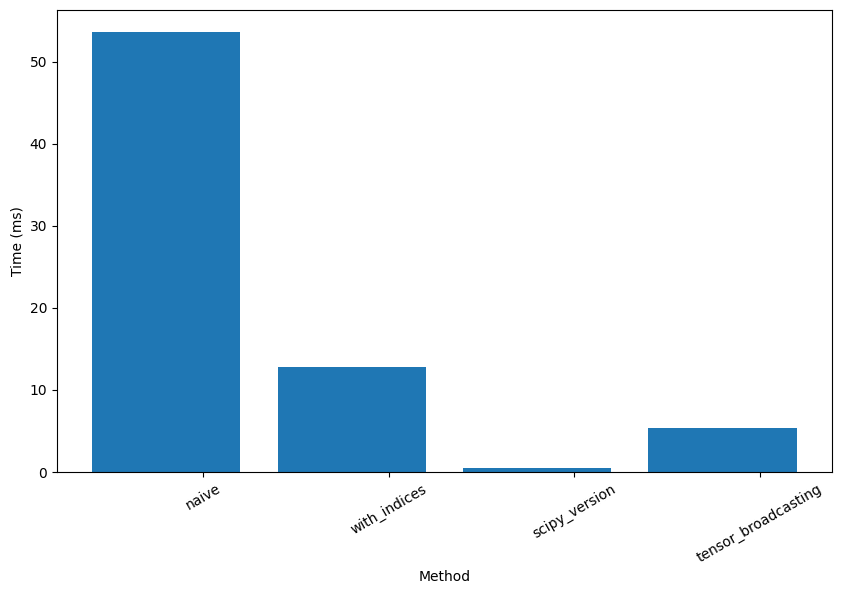

In [65]:
plt.figure(figsize=(10, 6))
plt.bar(
    np.arange(len(methods)), [r.best * 1000 for r in timers], log=False
)  # Set log to True for logarithmic scale
plt.xticks(np.arange(len(methods)) + 0.2, [f.__name__ for f in methods], rotation=30)
plt.xlabel("Method")
plt.ylabel("Time (ms)")
plt.show()